# News Article Summarization and Keyword Extraction via NLP

In this demo, we will create an NLP pipeline that will summarize and extract keywords from a news article URL. We will be using state-of-the-art transformer models such as BERT to perform these NLP tasks.

Additionally, we will be using MLRun's real-time inference graphs to create the pipeline. This allows for easy containerization and deployment of our pipeline on top of a production-ready Kubernetes cluster.

The full pipeline will do the following:
1. Retrieve news article text and metadata from URL using newspaper3k
2. Summarize article text via Huggingface pipeline using DistilBart model
3. Extract article keywords via KeyBERT using BERT-embeddings and cosine similarity
4. Remove the original article text from the response (optional)
5. Persist record in KV table

### Install Local Dependencies

In [ ]:
!pip install transformers==4.11.3 newspaper3k==0.2.8 keybert~=0.7.0

### Define MLRun Function
Here we define the serverless function that will containerize and deploy our application. We can add dependencies and commands to the image build, define replicas for scaling, add environment variables, and more.

In [2]:
import os
import mlrun

In [3]:
project_name = "nlp-demo"
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2022-11-22 13:12:45,271 [info] loaded project nlp-demo from MLRun DB


In [4]:
fn = mlrun.code_to_function(name="news-article-nlp", filename="nlp_transformations.py",
                            kind="serving", image='mlrun/mlrun')
fn.spec.min_replicas = 1
fn.spec.max_replicas = 1
fn.spec.build.commands = [
    "python -m pip install transformers==4.11.3 newspaper3k==0.2.8 keybert~=0.7.0",
    "python -c 'from transformers import pipeline; pipeline(\"summarization\")'",
    "python -c 'from keybert import KeyBERT; KeyBERT()'"
]
fn.set_env("SENTENCE_TRANSFORMERS_HOME","/tmp")
fn.set_env("TRANSFORMERS_CACHE","/tmp")

### Define Real-Time Serving Graph
Here we will orchestrate the functions and classes we want to run in our pipeline. The source code for these functions is located in `project/nlp_transformations.py`. Notice, this is the same file we used when running `code_to_function` in the cell above.

In [5]:
redis_url = None # Initialize with your redis url. e.g redis://:@102.278.258.221:32244

if not redis_url:
    if os.environ.get('V3IO_ACCESS_KEY'): # Running on iguazio platform
        container = "bigdata"
        table_path = f"nlp-{os.getenv('V3IO_USERNAME')}"
        key = "title"

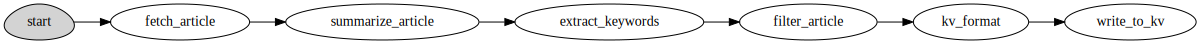

In [6]:
graph = fn.set_topology("flow", engine="async")

graph.to(name="fetch_article", handler="fetch_article")\
     .to(name="summarize_article", class_name="SummarizeArticle")\
     .to(name="extract_keywords", class_name="ExtractKeywords")\
     .to(name="filter_article", handler="filter_article")\
     .to(name="kv_format", handler="kv_format", full_event=True)

# On Iguazio's setup, V3IO fuse is enabled and using storey's steps we can write data to a KV table.
# when using community-edition, Redis service has to be deployed, and using mlrun's redisnosql target
# create a custom additional writing step.

if redis_url: # writing to redis
    graph.add_step(name='write_to_redis',class_name="storey.NoSqlTarget", table=redis_url, after='kv_format')

elif os.environ.get('V3IO_ACCESS_KEY'):
        graph.add_step(name="write_to_kv", class_name="storey.NoSqlTarget", table=f"v3io:///{container}/{table_path}", after='kv_format').respond()
else:
    print("skip writing")

graph.plot(rankdir='LR')

### Test the Pipeline Locally (using simulator)

In [7]:
# import the step functions for simulation
from nlp_transformations import *

# create a mock server (simulator)
server = fn.to_mock_server()

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)


In [8]:
# test the pipeline
server.test("/", body={"url" : "https://edition.cnn.com/2022/10/23/motorsport/dietrich-mateschitz-tributes-red-bull-spt-intl/index.html"})

{'url': 'https://edition.cnn.com/2022/10/23/motorsport/dietrich-mateschitz-tributes-red-bull-spt-intl/index.html',
 'title': 'Dietrich Mateschitz: Tributes paid to Red Bull founder',
 'authors': '["Aimee Lewis"]',
 'publish_date': '2022-10-23 00:00:00',
 'summarized_text': ' Austrian co-founder Dietrich Mateschitz has died aged 78 . The 78-year-old co-founded the Red Bull Formula One team and founded the energy drink company . Red Bull can win a fifth constructors’ title at the United States Grand Prix at the Circuit of the Americas in Austin .',
 'keywords': '["f1", "dietrich", "saddened", "constructors", "alphatauri"]'}

### Containerize and Deploy Pipeline on K8s
Here we easily containerize and deploy our application to our K8s cluster with a single command.

In [9]:
fn.spec.readinessTimeoutSeconds = 60 * 20  # 20 minutes.\n",
fn.deploy()

> 2022-11-22 13:13:27,937 [info] Starting remote function deploy
2022-11-22 13:13:28  (info) Deploying function
2022-11-22 13:13:28  (info) Building
2022-11-22 13:13:28  (info) Staging files and preparing base images
2022-11-22 13:13:28  (info) Building processor image
2022-11-22 13:16:13  (info) Build complete
2022-11-22 13:16:39  (info) Function deploy complete
> 2022-11-22 13:16:40,480 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-nlp-demo-dani-news-article-nlp.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['nlp-demo-dani-news-article-nlp-nlp-demo-dani.default-tenant.app.vmdev94.lab.iguazeng.com/']}


'http://nlp-demo-dani-news-article-nlp-nlp-demo-dani.default-tenant.app.vmdev94.lab.iguazeng.com/'

### Test Pipeline with URLs From Various News Sources 
Here we can test the pipeline with various news sources. This pipeline should work with any source compatible with the `newspaper3k` Python library.

In [10]:
fn.invoke(
    path="/",
    body={"url" : "https://edition.cnn.com/2022/10/22/china/china-party-congress-overseas-students-protest-intl-hnk/index.html"}
)

> 2022-11-22 13:16:40,570 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-dani-news-article-nlp.default-tenant.svc.cluster.local:8080/'}


{'url': 'https://edition.cnn.com/2022/10/22/china/china-party-congress-overseas-students-protest-intl-hnk/index.html',
 'title': 'Anti-Xi protest spreads in China and worldwide as Chinese leader begins third term',
 'authors': '["Cnn Staff"]',
 'publish_date': '2022-10-22 00:00:00',
 'summarized_text': ' Anti-Xi slogans have popped up in a growing number of Chinese cities and hundreds of universities worldwide . CNN spoke with two Chinese citizens who scribbled slogans in bathroom stalls and half a dozen overseas Chinese students who put up anti-Xi posters on their campuses . China’s party has ramped up surveillance and control of the Chinese diaspora, intimidating and harassing those who dare to speak out .',
 'keywords': '["jolie", "tiananmen", "scribbled", "a4", "risks"]'}

In [11]:
fn.invoke(
    path="/",
    body={"url" : "https://edition.cnn.com/2022/10/23/entertainment/matthew-perry-jennifer-aniston-alcohol/index.html"}
)

> 2022-11-22 13:17:02,242 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-dani-news-article-nlp.default-tenant.svc.cluster.local:8080/'}


{'url': 'https://edition.cnn.com/2022/10/23/entertainment/matthew-perry-jennifer-aniston-alcohol/index.html',
 'title': 'Jennifer Aniston confronted Matthew Perry about his substance abuse during Friends years',
 'authors': '["Dan Heching"]',
 'publish_date': '2022-10-23 00:00:00',
 'summarized_text': ' Matthew Perrys new book, "Friends, Lovers and the Big Terrible Thing, will be published November 1 . The actor says he was addicted to Vicodin and alcohol during his run on NBCs "Friends" He says a visit from costar Jennifer Aniston made him realize he was drinking too much .',
 'keywords': '["sober", "yards", "aniston", "perry", "migraines"]'}

In [12]:
fn.invoke(
    path="/",
    body={"url" : "https://www.npr.org/2022/10/24/1130915534/the-houston-astros-and-philadelphia-phillies-will-face-each-other-in-the-world-s"}
)

> 2022-11-22 13:17:18,515 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-dani-news-article-nlp.default-tenant.svc.cluster.local:8080/'}


{'url': 'https://www.npr.org/2022/10/24/1130915534/the-houston-astros-and-philadelphia-phillies-will-face-each-other-in-the-world-s',
 'title': 'The Houston Astros and Philadelphia Phillies will face each other in the World Series',
 'authors': '["Npr Staff"]',
 'publish_date': '2022-10-24 00:00:00',
 'summarized_text': ' The Houston Astros beat the New York Yankees 6-5 to advance to the World Series . The Phillies defeated the San Diego Padres 4-3 in the playoffs . The Astros advanced to 7-0 in this years postseason after sweeping the Seattle Mariners . The Philadelphia Phillies will play Houston in the Fall Classic on Friday .',
 'keywords': '["astros", "deficit", "hasn", "330", "dramatic"]'}

In [13]:
fn.invoke(
    path="/",
    body={"url" : "https://abcnews.go.com/Politics/jan-committee-trumps-testimony-circus-cheney/story?id=91963586",
          "filter_article" : False}
)

> 2022-11-22 13:17:31,596 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-dani-news-article-nlp.default-tenant.svc.cluster.local:8080/'}


{'url': 'https://abcnews.go.com/Politics/jan-committee-trumps-testimony-circus-cheney/story?id=91963586',
 'filter_article': False,
 'title': 'Jan. 6 committee wont let Trumps testimony become a circus, Cheney says',
 'authors': '["Abc News"]',
 'publish_date': 'None',
 'original_text': 'The former president was subpoenaed last week; he hasnt said if he will comply.\n\nRep. Liz Cheney said Sunday that while the House Jan. 6 committee was "anticipating" that former President Donald Trump would comply with the subpoena the panel issued to him last week, "Hes not going to turn this into a circus."\n\nThat meant that committee members likely werent interested in Trump testifying live before the committee in a public setting, as some past witnesses have, Cheney, R-Wyo., said on NBCs "Meet the Press."\n\n"The committee treats this matter with great seriousness," she said. "And we are going to proceed in terms of the questioning of the former president under oath. It may take multiple days. A

### Define KV Table Schema for Dashboard
While a schema is not required to write records to a table, it is required for the table to be displayed in a Grafana dashboard.

In [14]:
if os.environ.get('V3IO_ACCESS_KEY') :

    print ("creating key value schema")

    import v3io.dataplane

    v3io_client = v3io.dataplane.Client()

    v3io_client.kv.create_schema(
        container=container,
        table_path=table_path,
        key=key,
        fields = [
            {'name': 'url',
             'type': 'string',
             'nullable': False},
            {'name': 'filter_article',
             'type': 'boolean',
             'nullable': False},
            {'name': 'title',
             'type': 'string',
             'nullable': False},
            {'name': 'authors',
             'type': 'string',
             'nullable': False},
            {'name': 'publish_date',
             'type': 'string',
             'nullable': False},
            {'name': 'original_text',
             'type': 'string',
             'nullable': False},
            {'name': 'summarized_text',
             'type': 'string',
             'nullable': False},
            {'name': 'keywords',
             'type': 'string',
             'nullable': False}
        ]
    )

creating key value schema


### View Dashboard

After using the pipeline, we will be able to visualize the article summary, keywords, and metadata in a Grafana dashboard. The JSON file for the dashboard is available under `grafana_dashboard.json`.

After importing into Grafana and running the pipeline above, the dashboard will look something like the following:
![](./dashboard_preview.png)